In [1]:
import sys
"/drive" in sys.path or sys.path.append("/drive")
from patankar.private.pubchempy import get_compounds, Compound
for compound in get_compounds('glucose', 'name'):
    print(compound.cid)
    print(compound.isomeric_smiles)
vioxx = Compound.from_cid(5090)
print(vioxx.molecular_formula)
print(vioxx.molecular_weight)
print(vioxx.xlogp)

5793
C([C@@H]1[C@H]([C@@H]([C@H](C(O1)O)O)O)O)O
C17H14O4S
314.4
2.3


In [1]:
import sys
import micropip
await micropip.install("numpy")
await micropip.install("pandas")
await micropip.install("ipywidgets")
await micropip.install("nbformat")
await micropip.install("Pillow")
from IPython.display import display, HTML
"/drive" in sys.path or sys.path.append("/drive")  # Add the correct path for SFPPylite
from utils.nbutils import create_files_widget, create_header_footer, create_notebook_explorer   # SFPPy utilities for notebooks
(header,footer,separator) = create_header_footer(title="SFPPylite - Debug Environment 📑",what="all"); display(header, separator)

In [6]:
import importlib
import patankar.loadpubchem 
importlib.reload(patankar.loadpubchem)
from patankar.loadpubchem import migrant

In [ ]:
m = migrant('Cyclohexylbenzene')

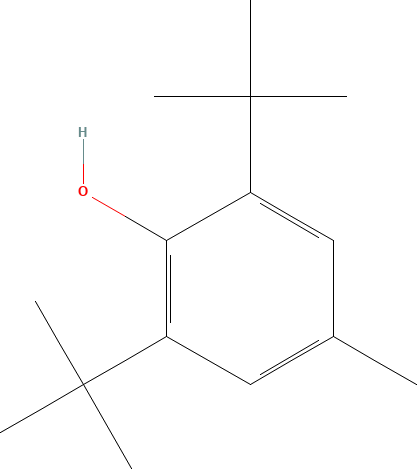

In [4]:
m = migrant("BHT")
m
m.image

In [ ]:
m = migrant("phenylcyclohexane")

In [ ]:
m.image

# Trace of previous apttemps in a single thread environment
> None of the solutions below have been implemented.
> Please refer to code above which is canonical and works with the workaround currently implemented (https://pubchempy.readthedocs.io/en/latest/)

In [20]:
import sys, os
"/drive" in sys.path or sys.path.append("/drive")  
import utils.asyncbridge
import importlib
importlib.reload(utils.asyncbridge)
from utils.asyncbridge import sync_async_to_file



async def post_request_async(url, data_dict, output_file, headers=None):
    from pyodide.http import pyfetch
    from urllib.parse import urlencode
    import os

    data = urlencode(data_dict)
    headers = headers or {"Content-Type": "application/x-www-form-urlencoded"}
    response = await pyfetch(url, method="POST", headers=headers, body=data.encode("utf-8"))
    result = await response.bytes()

    with open(output_file, "wb") as f:
        f.write(result)

# Call it synchronously
url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/property/CanonicalSMILES/JSON"
postdata = {"cid": 5793}

response_bytes = sync_async_to_file(post_request_async, args=(url, postdata))
import json
print(json.loads(response_bytes.decode())["PropertyTable"]["Properties"][0]["CanonicalSMILES"])


▶️ Starting sync_async_to_file: ('https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/property/CanonicalSMILES/JSON', {'cid': 5793}), output_file=/drive/utils/async/20250325071808250000.json
⏰ Timeout expired while waiting for file.


<class 'TimeoutError'>: Timeout waiting for async result file: /drive/utils/async/20250325071808250000.json

⏳ Scheduling async function...
✅ Async function completed.


In [27]:
import os
import time
import asyncio
from datetime import datetime, timezone
import json

class AsyncRegister:
    def __init__(self, output_dir="/drive/utils/async", debugmode=False):
        """ Initialize the asyncregister with an output directory for result files and an optional debug mode for logging. """
        self.output_dir = output_dir
        self.debugmode = debugmode
        os.makedirs(self.output_dir, exist_ok=True)

    def log(self, msg):
        """
        Log a message both to stdout and to a debug log file (if debugmode is True).
        """
        if self.debugmode:
            with open(os.path.join(self.output_dir, "debug.log"), "a") as f:
                f.write(msg + "\n")
        print(msg, flush=True)

    def register(self, async_fn, *args, **kwargs):
        """
        Register an asynchronous function, wrap it with a callback that writes its result
        to a file, and schedule its execution.

        Parameters:
            async_fn: The asynchronous function to execute. It must accept an 'output_file'
                    keyword argument and write its result to that file.
            *args: Positional arguments to pass to async_fn.
            **kwargs: Keyword arguments to pass to async_fn.

        Returns:
            output_file (str): The file path that will contain the result.
        """
        # Create a unique file name based on the current UTC timestamp.
        timestamp = datetime.now(timezone.utc).strftime("%Y%m%d%H%M%S%f")
        output_file = os.path.join(self.output_dir, f"{timestamp}.json")
        kwargs["output_file"] = output_file

        async def wrapper():
            self.log(f"⏳ Starting async task with output file: {output_file}")
            await async_fn(*args, **kwargs)
            self.log(f"✅ Async task completed with output file: {output_file}")

        # Schedule the asynchronous wrapper.
        asyncio.ensure_future(wrapper())
        return output_file

    def check_completion(self, output_file, timeout=10, poll_interval=0.1, decode_json=False, cleanup=True, raiseerror=True):
        """
        Poll for completion of the asynchronous task by checking for the existence
        of the output_file. Once found, read and return its content.

        Parameters:
            output_file (str): The file path to check.
            timeout (float): Maximum time (in seconds) to wait.
            poll_interval (float): Time (in seconds) between polls.
            decode_json (bool): If True, decode the file content using json.loads.
            cleanup (bool): If True, delete the file after reading.

        Returns:
            bytes or dict: The raw content of the file or its JSON-decoded value.

        Raises:
            TimeoutError: If the file does not appear within the timeout period.
        """
        t0 = time.time()
        while not os.path.exists(output_file):
            if time.time() - t0 > timeout:
                self.log("⏰ Timeout expired while waiting for async task completion.")
                if raiseerror:
                    raise TimeoutError(f"Timeout waiting for async result file: {output_file}")
                else:
                    return
            #time.sleep(poll_interval)

        if os.path.exists(output_file):
            self.log(f"📁 File found: {output_file}")
            with open(output_file, "rb") as f:
                content = f.read()
        else:
            raise RunTimeError("Unable to complete the task")
        
        if cleanup:
            try:
                os.remove(output_file)
                self.log(f"🧹 Cleaned up file: {output_file}")
            except Exception as e:
                self.log(f"⚠️ Could not delete file: {e}")
        return json.loads(content) if decode_json else content



async def post_request_async(url, data_dict, output_file, headers=None):
    from pyodide.http import pyfetch
    from urllib.parse import urlencode
    # Encode the data dictionary as application/x-www-form-urlencoded
    data = urlencode(data_dict)
    headers = headers or {"Content-Type": "application/x-www-form-urlencoded"}
    # Make the POST request
    response = await pyfetch(url, method="POST", headers=headers, body=data.encode("utf-8"))
    result = await response.bytes()
    # Write the result to the designated file.
    with open(output_file, "wb") as f:
        f.write(result)


reg = AsyncRegister(debugmode=True)
url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/property/CanonicalSMILES/JSON"
postdata = {"cid": 5793}
output_file = reg.register(post_request_async, url, postdata)
try:
    # Poll for completion. If the file appears within the timeout, the result is returned.
    result = reg.check_completion(output_file, timeout=1, poll_interval=0.1, decode_json=True, cleanup=False, raiseerror=False)
    # Process the result as needed.
    if result:
        print(result["PropertyTable"]["Properties"][0]["CanonicalSMILES"])
    else:
        print("no result yet")
except TimeoutError as e:
    print(str(e))
# if time out
print("*"*10,"second try")
print(output_file,os.path.isfile(output_file))
result2 = reg.check_completion(output_file, timeout=0.4, poll_interval=0.1, decode_json=True, cleanup=False)
print(result2["PropertyTable"]["Properties"][0]["CanonicalSMILES"])

⏰ Timeout expired while waiting for async task completion.
no result yet
********** second try
/drive/utils/async/20250325084104830000.json False
⏰ Timeout expired while waiting for async task completion.
⏳ Starting async task with output file: /drive/utils/async/20250325084104830000.json


<class 'TimeoutError'>: Timeout waiting for async result file: /drive/utils/async/20250325084104830000.json

✅ Async task completed with output file: /drive/utils/async/20250325084104830000.json


In [19]:
print(output_file)
result2 = reg.check_completion(output_file, timeout=0.4, poll_interval=0.1, decode_json=True, cleanup=False)
print(result2["PropertyTable"]["Properties"][0]["CanonicalSMILES"])

/drive/utils/async/20250325082859073000.json
📁 File found: /drive/utils/async/20250325082859073000.json
C(C1C(C(C(C(O1)O)O)O)O)O


In [28]:
import js
from urllib.parse import urlencode

def sync_post_fetch(url, data_dict, output_file, headers=None):
    """ Perform a synchronous POST request using JavaScript's XMLHttpRequest and write the result to a file."
    Parameters:
        url (str): The target URL.
        data_dict (dict): The POST data.
        output_file (str): Path to save the response.
        headers (dict): Optional HTTP headers (default: {"Content-Type": "application/x-www-form-urlencoded"}).
    """
    headers = headers or {"Content-Type": "application/x-www-form-urlencoded"}
    # Encode the data as application/x-www-form-urlencoded
    data = urlencode(data_dict)

    # Create a new XMLHttpRequest object
    xhr = js.XMLHttpRequest.new()

    # Open a synchronous request (third parameter False means synchronous)
    xhr.open("POST", url, False)

    # Set request headers
    for key, value in headers.items():
        xhr.setRequestHeader(key, value)

    # Send the request with the encoded data
    xhr.send(data)

    # Get the response text (alternatively, you can use xhr.response if needed)
    result = xhr.responseText

    # Write the result to the designated file
    with open(output_file, "w") as f:
        f.write(result)


url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/property/CanonicalSMILES/JSON"
postdata = {"cid": 5793}
output_file = "/drive/utils/async/sync_post_fetch_result.json"
sync_post_fetch(url, postdata, output_file)
with open(output_file, "r") as f:
    data = f.read()
    print("Response from PubChem:")
    print(data)

Response from PubChem:
{"PropertyTable":{"Properties":[{"CID":5793,"CanonicalSMILES":"C(C1C(C(C(C(O1)O)O)O)O)O"}]}}
